# <span style="color:white">**Projet ML - Bike Sharing**</span>

## <span style="color:powderblue">**Imports and Setup**</span>

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from datetime import datetime, date
from sklearn.metrics import mean_absolute_error, mean_squared_error

#import sklearn.svm as svm
#import sklearn.feature_selection as feature_select
#import sklearn.feature_extraction as feature_extract
#import sklearn.preprocessing as preprocessing
#import sklearn.neural_network as nn

In [220]:
day_df = pd.read_csv("./data/day.csv")
hour_df = pd.read_csv("./data/hour.csv")

In [221]:
def extract_day_of_month(df, date_column):
    df["day"] = pd.to_datetime(df[date_column]).dt.day
    return df

In [222]:
day_df = extract_day_of_month(day_df, "dteday")
hour_df = extract_day_of_month(hour_df, "dteday")

day_df['dteday'] = pd.to_datetime(day_df.dteday, format = '%Y-%m-%d')
hour_df['dteday'] = pd.to_datetime(hour_df.dteday, format = '%Y-%m-%d')

hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1


In [223]:
day_columns_order = ['instant','dteday', 'yr', 'season', 'mnth', 'day'] + [col for col in day_df.columns if col not in ['instant','dteday', 'yr', 'season', 'mnth', 'day']]
day_df = day_df[day_columns_order]
hour_columns_order = ['instant','dteday', 'yr', 'season', 'mnth', 'day', "hr"] + [col for col in hour_df.columns if col not in ['instant','dteday', 'yr', 'season', 'mnth', 'day','hr']]
hour_df = hour_df[hour_columns_order]

hour_df.head()

,instant,dteday,yr,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,1,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,0,1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,0,1,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,0,1,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,0,1,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [224]:
day_df.columns = ["instant","date", "year", "season", "month", "day", "holiday", "weekday", "workingday", "weathersit", "temperature", "felt_temperature", "humidity", "windspeed", "casual", "registered", "count"]
hour_df.columns = ["instant","date", "year", "season", "month", "day", "hour", "holiday", "weekday", "workingday", "weathersit", "temperature", "felt_temperature", "humidity", "windspeed", "casual", "registered", "count"]

In [225]:
targets = ["casual", "registered", "count"]
day_features = [feature for feature in day_df.columns if feature not in targets]
hour_features = [feature for feature in hour_df.columns if feature not in targets]

In [226]:
day_df.head()
#hour_df.head()

,instant,date,year,season,month,day,holiday,weekday,workingday,weathersit,temperature,felt_temperature,humidity,windspeed,casual,registered,count
0,1,2011-01-01,0,1,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,0,1,1,2,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,0,1,1,3,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,0,1,1,4,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,0,1,1,5,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## <span style="color:powderblue">**Data Visualization**</span>

### <span style="color:lightcyan">**Data visualization over time**</span>

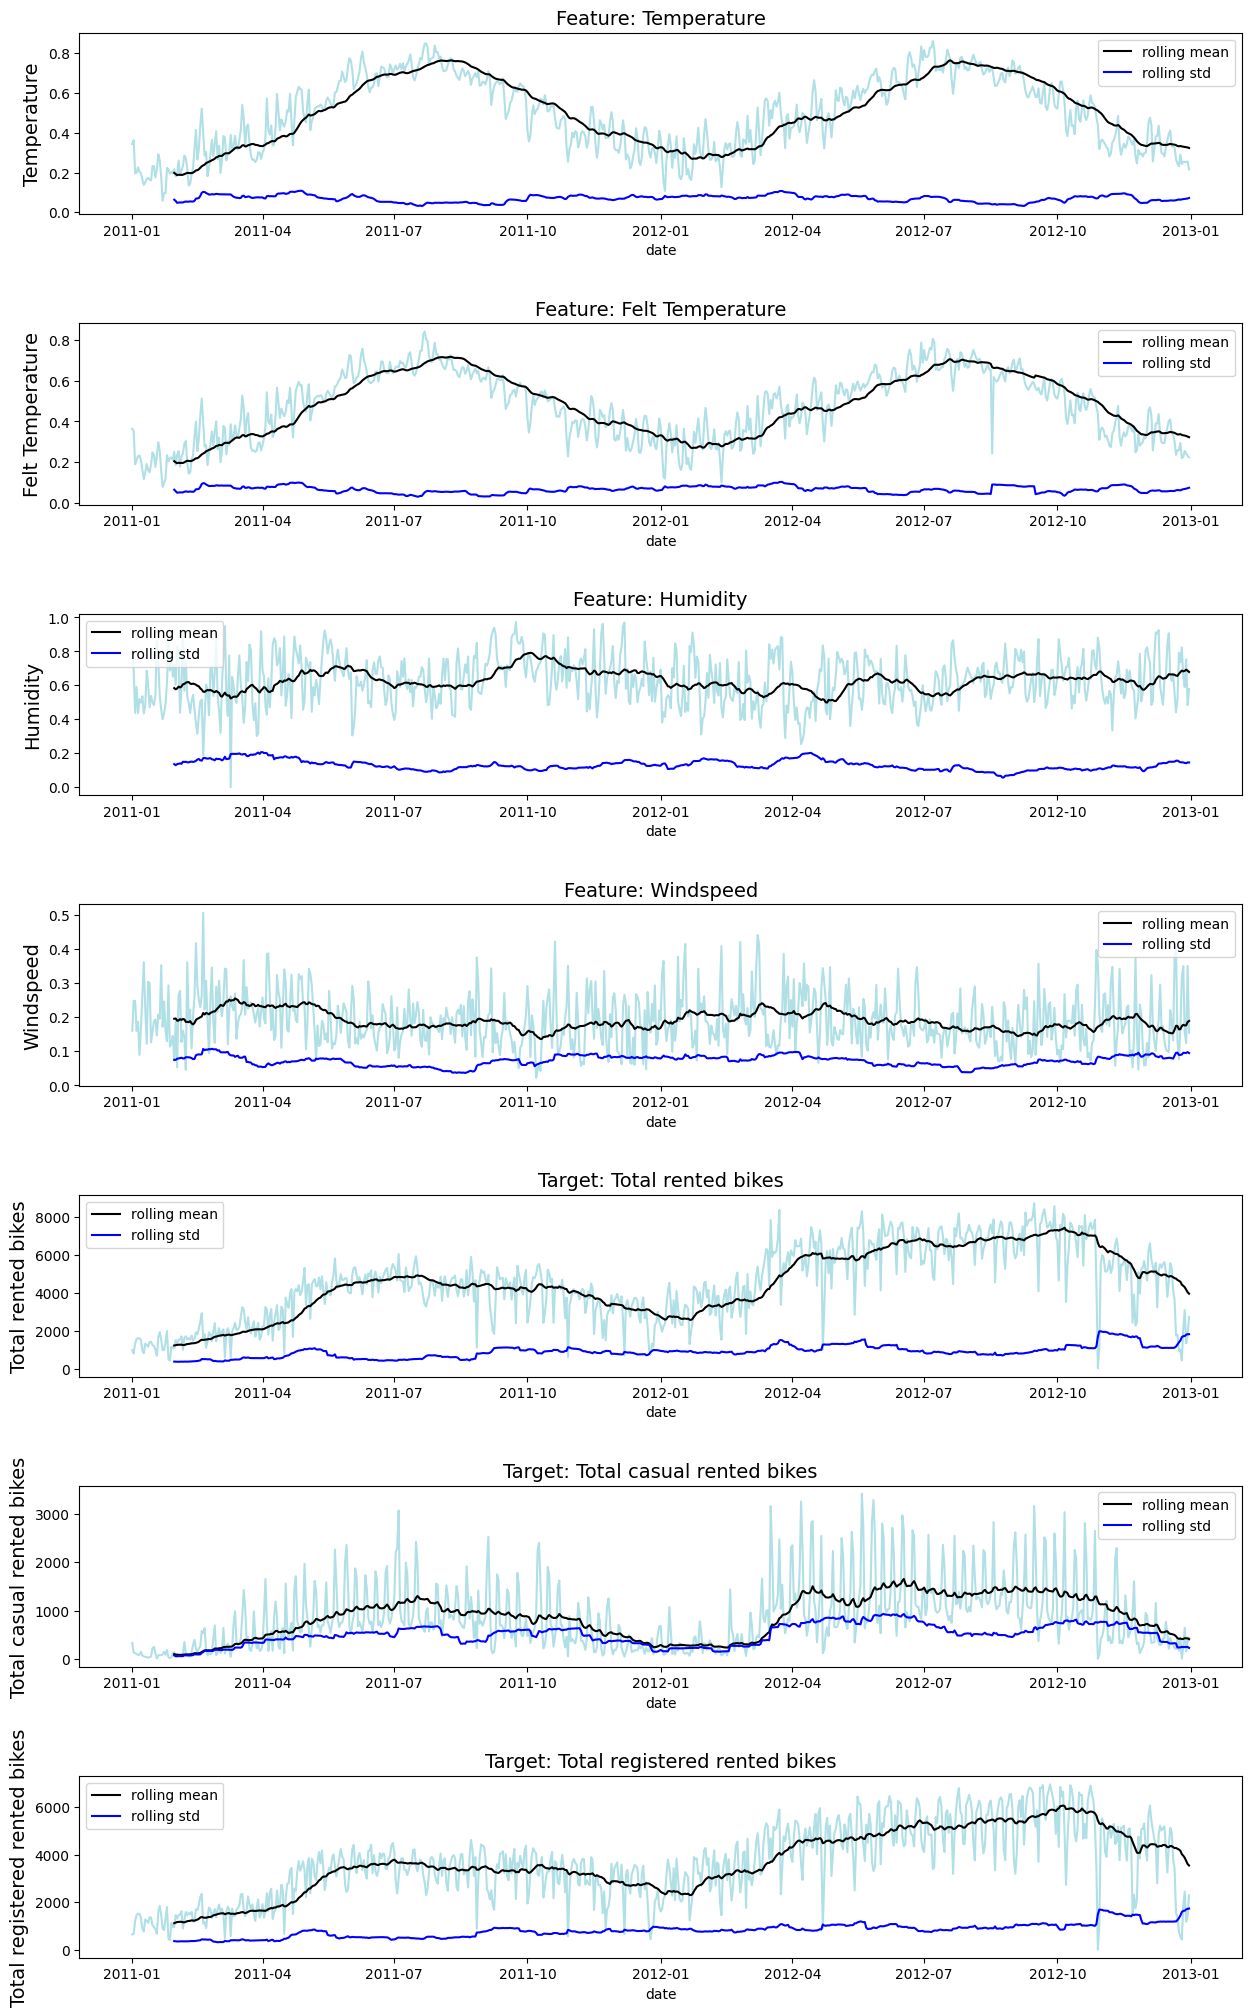

In [250]:
rolling_window = 30
f, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

sns.lineplot(x=day_df.date, y=day_df.temperature, ax=ax[0], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.temperature.rolling(rolling_window).mean(), ax=ax[0], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.temperature.rolling(rolling_window).std(), ax=ax[0], color='blue', label='rolling std')
ax[0].set_title('Feature: Temperature', fontsize=14)
ax[0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.felt_temperature, ax=ax[1], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.felt_temperature.rolling(rolling_window).mean(), ax=ax[1], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.felt_temperature.rolling(rolling_window).std(), ax=ax[1], color='blue', label='rolling std')
ax[1].set_title('Feature: Felt Temperature', fontsize=14)
ax[1].set_ylabel(ylabel='Felt Temperature', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.humidity, ax=ax[2], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.humidity.rolling(rolling_window).mean(), ax=ax[2], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.humidity.rolling(rolling_window).std(), ax=ax[2], color='blue', label='rolling std')
ax[2].set_title('Feature: Humidity', fontsize=14)
ax[2].set_ylabel(ylabel='Humidity', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.windspeed, ax=ax[3], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.windspeed.rolling(rolling_window).mean(), ax=ax[3], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.windspeed.rolling(rolling_window).std(), ax=ax[3], color='blue', label='rolling std')
ax[3].set_title('Feature: Windspeed', fontsize=14)
ax[3].set_ylabel(ylabel='Windspeed', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df["count"], ax=ax[4], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df["count"].rolling(rolling_window).mean(), ax=ax[4], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df["count"].rolling(rolling_window).std(), ax=ax[4], color='blue', label='rolling std')
ax[4].set_title('Target: Total rented bikes', fontsize=14)
ax[4].set_ylabel(ylabel='Total rented bikes', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.casual, ax=ax[5], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.casual.rolling(rolling_window).mean(), ax=ax[5], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.casual.rolling(rolling_window).std(), ax=ax[5], color='blue', label='rolling std')
ax[5].set_title('Target: Total casual rented bikes', fontsize=14)
ax[5].set_ylabel(ylabel='Total casual rented bikes', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.registered, ax=ax[6], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.registered.rolling(rolling_window).mean(), ax=ax[6], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.registered.rolling(rolling_window).std(), ax=ax[6], color='blue', label='rolling std')
ax[6].set_title('Target: Total registered rented bikes', fontsize=14)
ax[6].set_ylabel(ylabel='Total registered rented bikes', fontsize=14)

plt.subplots_adjust(hspace=0.6)
plt.show()

Trend and seasonality : ARIMA model not best suited for this as it assumes that underlying data is stationary (constant mean and not time-dependent, constant variance and not time dependent, constant covariance and not time-dependent) which is not the case here), strong seasonality for temperatures, for rentals, debatable for windspeed and humidity

### <span style="color:lightcyan">**Focus on Days**</span>

In [228]:
#day_df.count()
#day_df[["cnt","casual","registered"]].describe().round(1)

#### **Distribution of Bike Rentals**

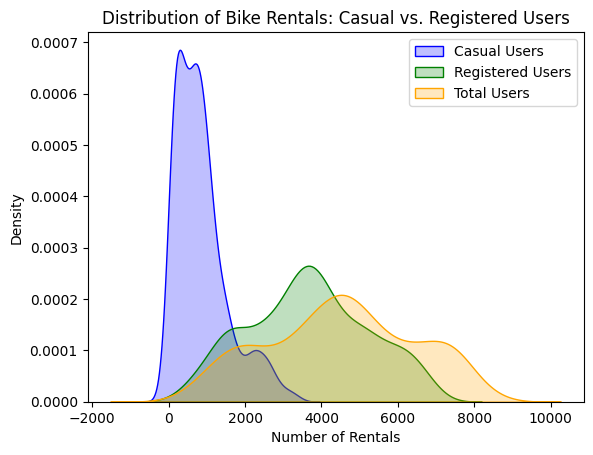

In [229]:
sns.kdeplot(day_df['casual'], fill=True, label='Casual Users', color='blue')
sns.kdeplot(day_df['registered'], fill=True, label='Registered Users', color='green')
sns.kdeplot(day_df['count'], fill=True, label="Total Users", color='orange')
plt.title("Distribution of Bike Rentals: Casual vs. Registered Users")
plt.xlabel("Number of Rentals")
plt.ylabel("Density")
plt.legend()

#### **Bike rentals over time by season**

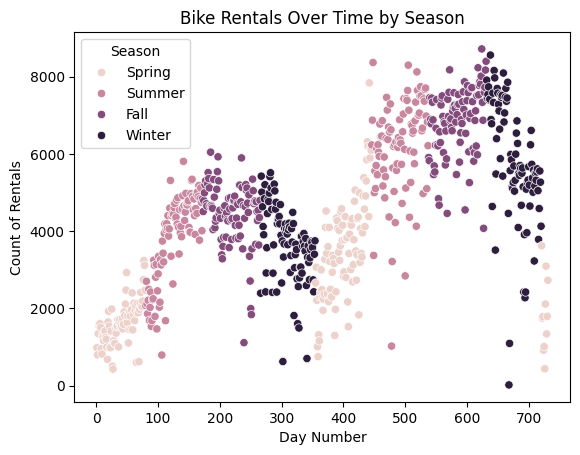

In [230]:
scatter = sns.scatterplot(day_df,x="instant",y="count",hue=day_df["season"])
handles, _ = scatter.get_legend_handles_labels()
plt.title("Bike Rentals Over Time by Season")
plt.xlabel("Day Number")
plt.ylabel("Count of Rentals")
plt.legend(handles=handles, title="Season", labels=["Spring", "Summer", "Fall", "Winter"])

#### **Bike rentals per weekdays**

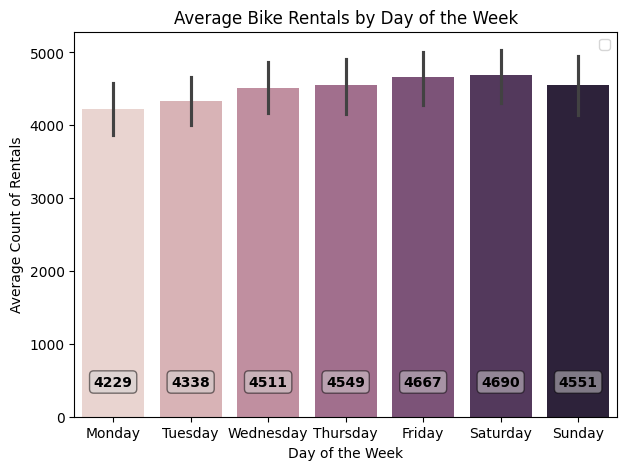

In [231]:
plt.figure(figsize=(7,5))
barplot = sns.barplot(data=day_df, x="weekday", y="count", hue=day_df["weekday"])
plt.title("Average Bike Rentals by Day of the Week")
plt.xticks(ticks=range(7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xlabel("Day of the Week")
plt.ylabel("Average Count of Rentals")
plt.legend([], [])

y_min = plt.gca().get_ylim()[0]

# Annotate each bar with a constant y-position, adding a rounded rectangle box with shading
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if the height is greater than zero
        barplot.annotate(f'{height:.0f}', 
                         (p.get_x() + p.get_width() / 2., y_min),
                         ha='center', va='center', 
                         fontsize=10, color='black', 
                         fontweight='bold',  # Make the font bold
                         xytext=(0, 25),  # No additional offset needed
                         textcoords='offset points',
                         bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgray", alpha=0.5))

#### **Bike rentals by temperature**

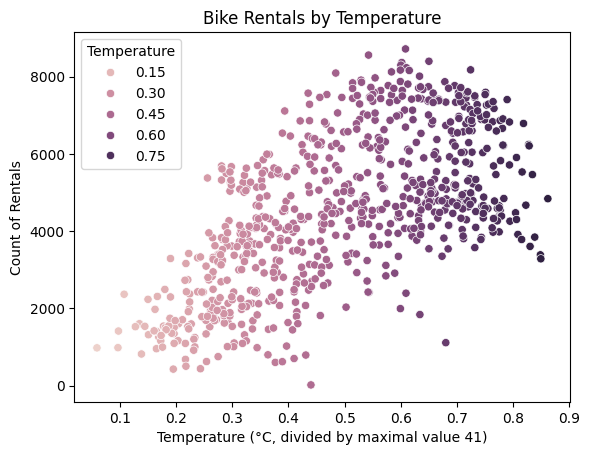

In [232]:
sns.scatterplot(day_df,x="temperature",y="count",hue=day_df["temperature"])
plt.title("Bike Rentals by Temperature")
plt.xlabel("Temperature (°C, divided by maximal value 41)")
plt.ylabel("Count of Rentals")
plt.legend(title="Temperature")

Text(15.875000000000009, 0.5, 'Count of Rentals')

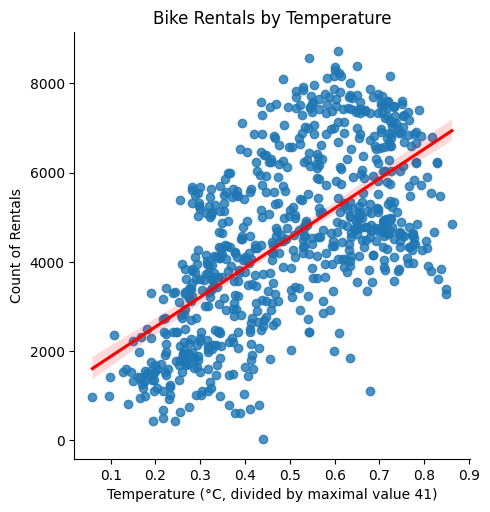

In [233]:
sns.lmplot(data=day_df, x="temperature", y="count",aspect=1, line_kws={'color': 'red'})
plt.title("Bike Rentals by Temperature")
plt.xlabel("Temperature (°C, divided by maximal value 41)")
plt.ylabel("Count of Rentals")

#### **Bike rentals by temperature felt**

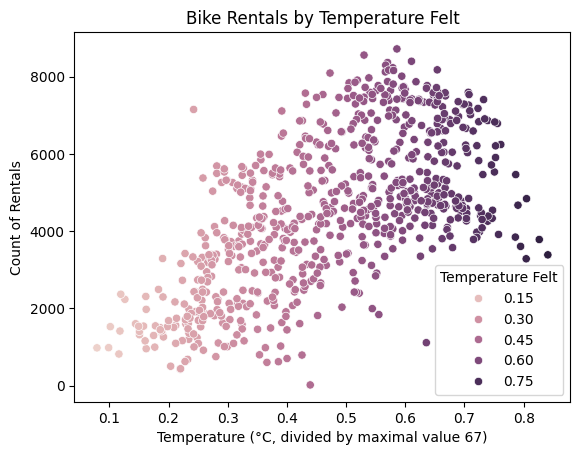

In [234]:
sns.scatterplot(day_df,x="felt_temperature",y="count",hue=day_df["felt_temperature"])
plt.title("Bike Rentals by Temperature Felt")
plt.xlabel("Temperature (°C, divided by maximal value 67)")
plt.ylabel("Count of Rentals")
plt.legend(title="Temperature Felt")

Text(15.875000000000009, 0.5, 'Count of Rentals')

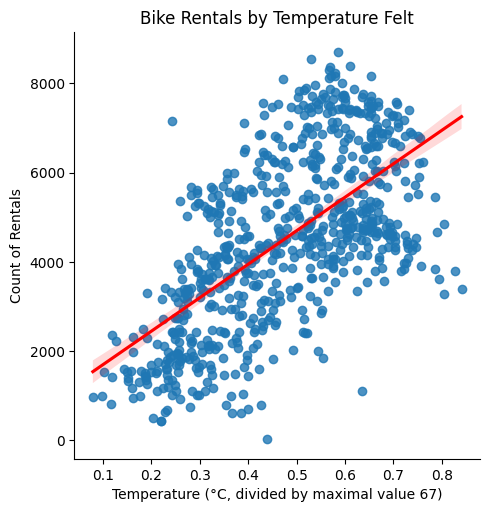

In [235]:
sns.lmplot(data=day_df, x="felt_temperature", y="count",aspect=1, line_kws={'color': 'red'})
plt.title("Bike Rentals by Temperature Felt")
plt.xlabel("Temperature (°C, divided by maximal value 67)")
plt.ylabel("Count of Rentals")

Clear correlation between temperature and bike rental amount (shocking)

#### **Bike rentals by humidity**

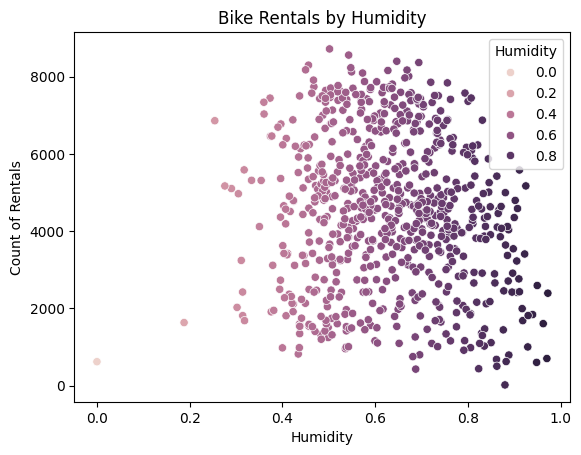

In [236]:
sns.scatterplot(day_df,x="humidity",y="count",hue=day_df["humidity"])
plt.title("Bike Rentals by Humidity")
plt.xlabel("Humidity")
plt.ylabel("Count of Rentals")
plt.legend(title="Humidity")

Text(15.875000000000009, 0.5, 'Count of Rentals')

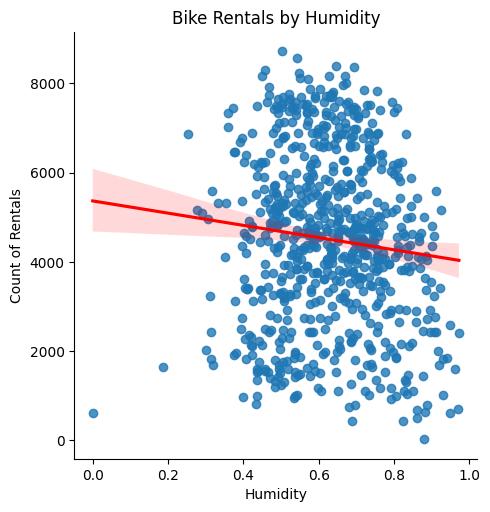

In [237]:
sns.lmplot(data=day_df, x="humidity", y="count",aspect=1, line_kws={'color': 'red'})
plt.title("Bike Rentals by Humidity")
plt.xlabel("Humidity")
plt.ylabel("Count of Rentals")

#### **Bike rentals by weather conditions**

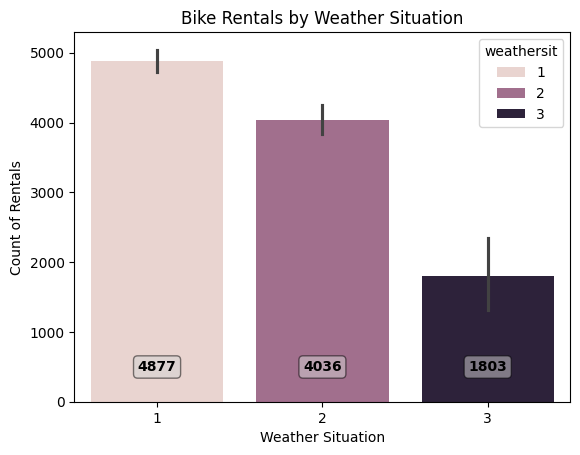

In [238]:
barplot = sns.barplot(data=day_df, x="weathersit", y="count", hue=day_df["weathersit"])
plt.title("Bike Rentals by Weather Situation")
plt.xlabel("Weather Situation")
plt.ylabel("Count of Rentals")

y_min = plt.gca().get_ylim()[0]

# Annotate each bar with a constant y-position, adding a rounded rectangle box with shading
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if the height is greater than zero
        barplot.annotate(f'{height:.0f}', 
                         (p.get_x() + p.get_width() / 2., y_min),
                         ha='center', va='center', 
                         fontsize=10, color='black', 
                         fontweight='bold',  # Make the font bold
                         xytext=(0, 25),  # No additional offset needed
                         textcoords='offset points',
                         bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgray", alpha=0.5))

#### **Bike rental depending on wether the days are holidays or not**

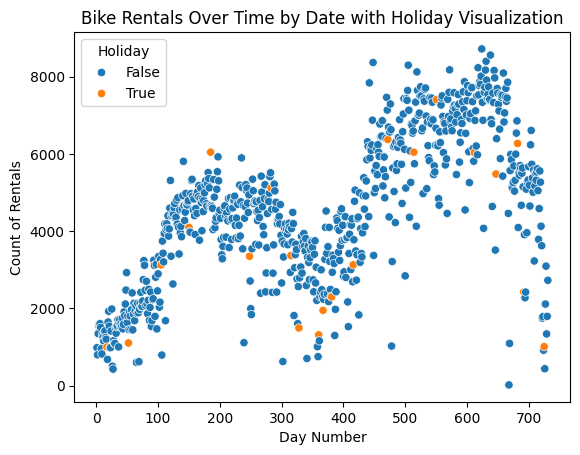

In [239]:
scatter = sns.scatterplot(day_df,x="instant",y="count",hue=day_df["holiday"])
handles, _ = scatter.get_legend_handles_labels()
plt.title("Bike Rentals Over Time by Date with Holiday Visualization")
plt.xlabel("Day Number")
plt.ylabel("Count of Rentals")
plt.legend(handles=handles, title="Holiday", labels=["False","True"])

No clear influence of holidays on the bike rental amount

### <span style="color:lightcyan">**Focus on Hours**</span>

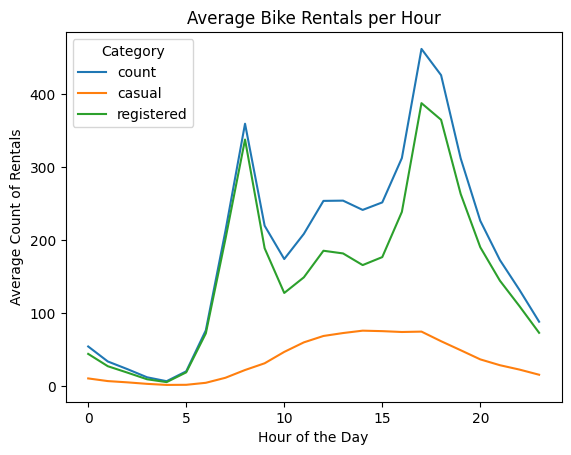

In [240]:
hourly_rentals = hour_df.groupby("hour")["count"].mean()
hourly_casual =  hour_df.groupby("hour")["casual"].mean()
hourly_registered =  hour_df.groupby("hour")["registered"].mean()
hourly_rentals.plot(kind='line')
hourly_casual.plot(kind='line')
hourly_registered.plot(kind='line')
plt.title("Average Bike Rentals per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Count of Rentals")
plt.legend(title="Category")
plt.grid(False)

### <span style="color:lightcyan">**Correlation Analysis**</span>

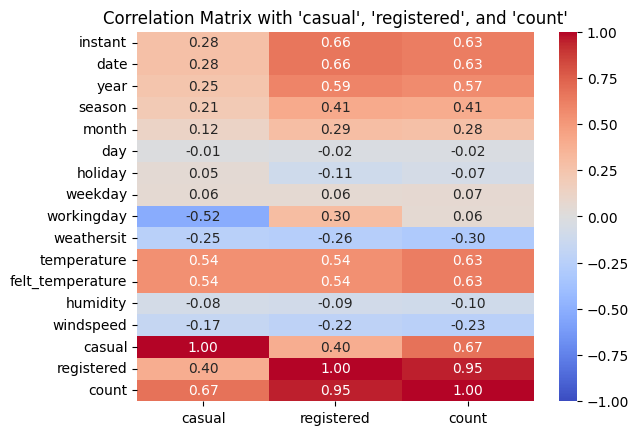

In [241]:
correlation_matrix = day_df.corr()
# Keep only the correlations with 'casual', 'registered', and 'cnt'
filtered_corr_matrix = correlation_matrix.loc[:, ['casual', 'registered', 'count']].copy()

sns.heatmap(filtered_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix with 'casual', 'registered', and 'count'")
plt.show()

## <span style="color:powderblue">**Data Analysis**</span>

### <span style="color:lightcyan">**Feature Selection**</span>

## <span style="color:powderblue">**Machine Learning**</span>

### <span style="color:lightcyan">**Time Series Forecasting**</span>